In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [3]:
ls

MyDrive/  Shareddrives/


In [4]:
cd/gdrive/MyDrive/clean VS messy room classification/

/gdrive/MyDrive/clean VS messy room classification


In [5]:
ls

clean/  messy/


In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [7]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [33]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=50
CHANNELS=3

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/clean VS messy room classification/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 192 files belonging to 2 classes.


In [11]:
class_names = dataset.class_names
class_names

['clean', 'messy']

In [12]:
len(dataset)

4

In [13]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[110.16797   118.16797   107.16797  ]
  [112.34375   120.34375   109.34375  ]
  [116.083984  124.083984  113.083984 ]
  ...
  [173.41992   180.        172.       ]
  [172.25195   179.25195   171.25195  ]
  [172.        179.        171.       ]]

 [[111.33594   119.33594   108.33594  ]
  [113.44824   121.44824   110.44824  ]
  [117.        125.        114.       ]
  ...
  [173.41992   180.        172.       ]
  [172.25195   179.25195   171.25195  ]
  [172.        179.        171.       ]]

 [[112.083984  120.083984  109.083984 ]
  [114.11362   122.11362   111.11362  ]
  [117.24359   125.24359   114.24359  ]
  ...
  [173.24359   180.        172.       ]
  [172.25195   179.25195   171.25195  ]
  [172.        179.        171.       ]]

 ...

 [[164.70117   143.44922   141.88878  ]
  [156.7345    129.60526   109.20062  ]
  [151.82784   109.77259    66.57337  ]
  ...
  [  6.          7.          8.7564125]
  [  6.          7.          9.       ]
  [  6.        

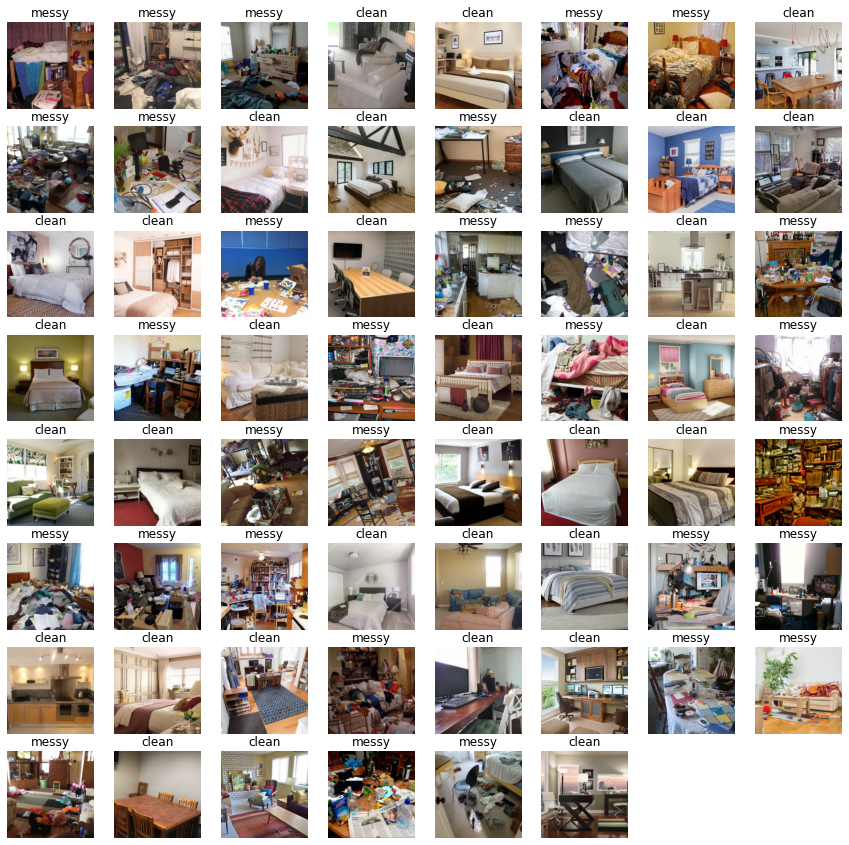

In [14]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
3/3 [==============================] - 14s 4s/step - loss: 0.3597 - accuracy: 0.9154
Epoch 2/50
3/3 [==============================] - 14s 7s/step - loss: 0.3019 - accuracy: 0.8923
Epoch 3/50
3/3 [==============================] - 14s 4s/step - loss: 0.2525 - accuracy: 0.9308
Epoch 4/50
3/3 [==============================] - 14s 4s/step - loss: 0.2137 - accuracy: 0.9462
Epoch 5/50
3/3 [==============================] - 14s 4s/step - loss: 0.2220 - accuracy: 0.9154
Epoch 6/50
3/3 [==============================] - 14s 4s/step - loss: 0.1719 - accuracy: 0.9462
Epoch 7/50
3/3 [==============================] - 14s 4s/step - loss: 0.1288 - accuracy: 0.9615
Epoch 8/50
3/3 [==============================] - 14s 4s/step - loss: 0.0996 - accuracy: 0.9769
Epoch 9/50
3/3 [==============================] - 14s 4s/step - loss: 0.0705 - accuracy: 0.9846
Epoch 10/50
3/3 [==============================] - 14s 4s/step - loss: 0.0502 - accuracy: 0.9923
Epoch 11/50
3/3 [======================

In [35]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.4587 - accuracy: 0.9032


[0.45873841643333435, 0.9032257795333862]

In [36]:
acc = history.history['accuracy']
loss = history.history['loss']

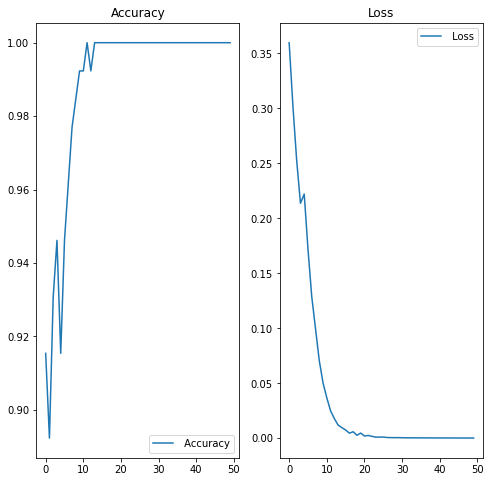

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

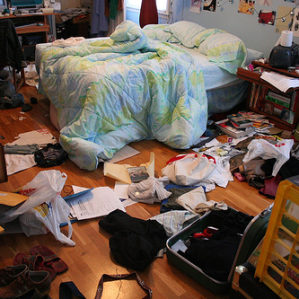

In [38]:
image_path = "/gdrive/My Drive/95.png"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [39]:
pred = model.predict(scaled_img)

In [40]:
output = class_names[np.argmax(pred)]

In [41]:
output

'messy'

In [32]:
model.save("clean vs messy room.h5")